In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/MyDrive/pneumonia_curated.zip" -d /content/

In [4]:
import os

base = "/content"

for split in ["train", "val", "test"]:
    for class_id, class_name in [(0, "pneumonia"), (1, "other"), (2, "normal")]:
        path = os.path.join(base, split, f"class_{class_id}_{class_name}")
        count = len(os.listdir(path))
        print(f"{split}/{class_name}: {count} images")


train/pneumonia: 700 images
train/other: 700 images
train/normal: 700 images
val/pneumonia: 150 images
val/other: 150 images
val/normal: 150 images
test/pneumonia: 150 images
test/other: 150 images
test/normal: 150 images


In [5]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [14]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [15]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_dir = "/content"

train_dataset = ImageFolder(f"{data_dir}/train", transform=train_transform)
val_dataset = ImageFolder(f"{data_dir}/val", transform=val_test_transform)
test_dataset = ImageFolder(f"{data_dir}/test", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes


In [16]:
import torch.nn as nn
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer only
model.fc = nn.Linear(model.fc.in_features, 3)

# Ensure the last layer is trainable
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)


In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)


In [18]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, save_path="best_model.pt"):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\n🟢 Epoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_acc = 100 * train_correct / train_total
        print(f"🔹 Train Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        print(f"🔸 Val Accuracy: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved new best model with Val Acc: {val_acc:.2f}%")

    print(f"\n🏁 Training finished. Best Val Accuracy: {best_val_acc:.2f}%")


In [19]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10,
    save_path="/content/drive/MyDrive/pneumonia_resnet18_best.pt"
)



🟢 Epoch 1/10


Training: 100%|██████████| 66/66 [04:10<00:00,  3.79s/it]


🔹 Train Loss: 1.1358, Accuracy: 33.19%
🔸 Val Accuracy: 29.56%
✅ Saved new best model with Val Acc: 29.56%

🟢 Epoch 2/10


Training: 100%|██████████| 66/66 [04:12<00:00,  3.82s/it]


🔹 Train Loss: 1.1046, Accuracy: 37.95%
🔸 Val Accuracy: 33.33%
✅ Saved new best model with Val Acc: 33.33%

🟢 Epoch 3/10


Training: 100%|██████████| 66/66 [04:10<00:00,  3.80s/it]


🔹 Train Loss: 1.0984, Accuracy: 38.62%
🔸 Val Accuracy: 34.44%
✅ Saved new best model with Val Acc: 34.44%

🟢 Epoch 4/10


Training: 100%|██████████| 66/66 [04:10<00:00,  3.80s/it]


🔹 Train Loss: 1.0834, Accuracy: 39.95%
🔸 Val Accuracy: 34.67%
✅ Saved new best model with Val Acc: 34.67%

🟢 Epoch 5/10


Training: 100%|██████████| 66/66 [04:11<00:00,  3.81s/it]


🔹 Train Loss: 1.0744, Accuracy: 42.05%
🔸 Val Accuracy: 34.89%
✅ Saved new best model with Val Acc: 34.89%

🟢 Epoch 6/10


Training: 100%|██████████| 66/66 [04:08<00:00,  3.76s/it]


🔹 Train Loss: 1.0726, Accuracy: 42.29%
🔸 Val Accuracy: 38.22%
✅ Saved new best model with Val Acc: 38.22%

🟢 Epoch 7/10


Training: 100%|██████████| 66/66 [04:07<00:00,  3.75s/it]


🔹 Train Loss: 1.0750, Accuracy: 41.95%
🔸 Val Accuracy: 35.78%

🟢 Epoch 8/10


Training: 100%|██████████| 66/66 [04:07<00:00,  3.75s/it]


🔹 Train Loss: 1.0653, Accuracy: 43.43%
🔸 Val Accuracy: 36.44%

🟢 Epoch 9/10


Training: 100%|██████████| 66/66 [04:06<00:00,  3.74s/it]


🔹 Train Loss: 1.0595, Accuracy: 43.67%
🔸 Val Accuracy: 36.67%

🟢 Epoch 10/10


Training: 100%|██████████| 66/66 [04:07<00:00,  3.75s/it]


🔹 Train Loss: 1.0567, Accuracy: 43.81%
🔸 Val Accuracy: 40.00%
✅ Saved new best model with Val Acc: 40.00%

🏁 Training finished. Best Val Accuracy: 40.00%


In [20]:
# Load model (same architecture as training)
from torchvision.models import resnet18
import torch.nn as nn

model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

# Load saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/pneumonia_resnet18_best.pt"))
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Accuracy
test_accuracy = (all_preds == all_labels).mean() * 100
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")



✅ Test Accuracy: 44.00%


In [22]:
from sklearn.metrics import classification_report

class_names = ["pneumonia", "other", "normal"]  # adjust based on your folder labels
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



📋 Classification Report:
              precision    recall  f1-score   support

   pneumonia       0.42      0.38      0.40       150
       other       0.41      0.43      0.42       150
      normal       0.49      0.51      0.50       150

    accuracy                           0.44       450
   macro avg       0.44      0.44      0.44       450
weighted avg       0.44      0.44      0.44       450



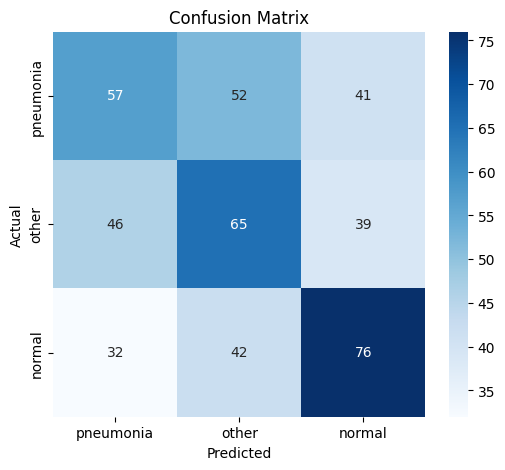

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [24]:
torch.save(model.state_dict(), "pneumonia_resnet18_weights.pth")


In [25]:
from google.colab import files
files.download("pneumonia_resnet18_weights.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>